#Alura latam TELECOMX_PARTE2


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

##Cargar Datos

In [2]:
# 1. Cargar datos desde URL (JSON)
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
response = requests.get(url)
df = response.json()
datos = pd.json_normalize(df)

In [3]:
datos_columnas_categoricas = ["Churn", "customer.Partner", "customer.Dependents",
                              "phone.PhoneService", "account.PaperlessBilling","customer.gender", "phone.MultipleLines", "internet.InternetService",
                 "internet.OnlineSecurity", "internet.OnlineBackup",
                 "internet.DeviceProtection", "internet.TechSupport",
                 "internet.StreamingTV", "internet.StreamingMovies",
                 "account.Contract", "account.PaymentMethod"]
datos_columnas_flotantes = ["account.Charges.Total"]

In [4]:
datos[datos_columnas_categoricas] = datos[datos_columnas_categoricas].astype("category")
datos["account.Charges.Total"] = datos["account.Charges.Total"].replace(" ", "0").astype("float64")


In [5]:
datos["Cuentas.diarias"] = datos["account.Charges.Total"] /30

In [7]:
# Reemplazamos cadenas vacías o espacios por NaN
datos['Churn'] = datos['Churn'].replace("", np.nan)
datos['account.Charges.Total'] = datos['account.Charges.Total'].replace(" ", np.nan)

# Eliminamos las filas donde Churn o Charges.Total sean NaN
datos = datos.dropna(subset=['Churn', 'account.Charges.Total'])

##Separamos columnas

In [8]:
# 2. Separar X e y
y = datos["Churn"].apply(lambda x: 1 if x == "Yes" else 0)  # Convertimos a 0/1
X = datos.drop(columns=["Churn"])

##Encoding

In [9]:
# 3. Encoding de variables categóricas
categoricas = X.select_dtypes(include=["category", "object"]).columns
one_hot = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categoricas),
    remainder="passthrough",
    sparse_threshold=0
)

X_encoded = one_hot.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded, columns=one_hot.get_feature_names_out(X.columns))


##Normalización o estandarización

In [10]:
# 4. Normalización (para KNN)
scaler = MinMaxScaler()
X_normalizado = scaler.fit_transform(X_encoded)


##Verificación de la Proporción de Cancelación

In [11]:
# 5. Proporción de churn
print("Proporción de churn:")
print(y.value_counts(normalize=True))

Proporción de churn:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


##Analisis de correlación

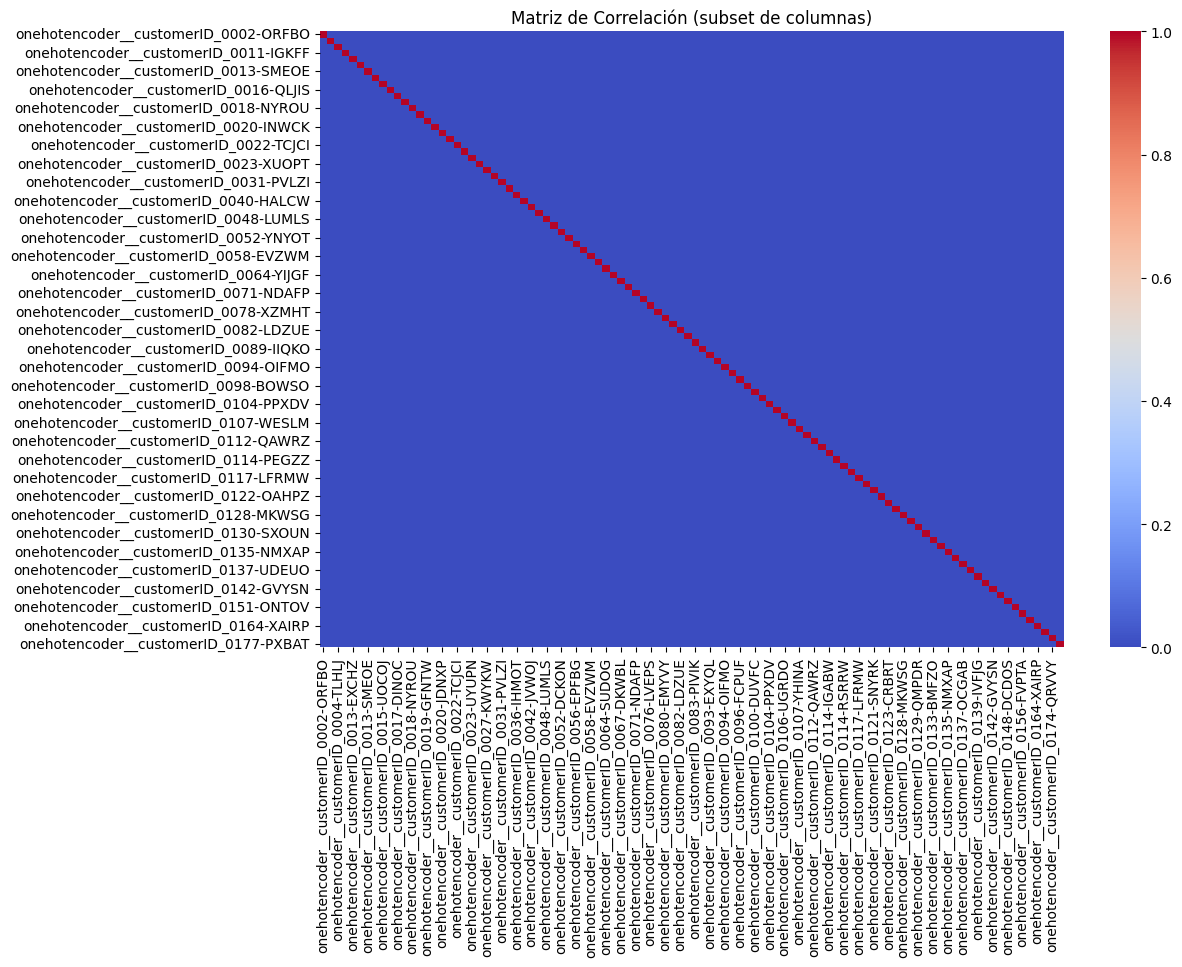

In [12]:
# Solo primeras 30 columnas por ejemplo
subset_cols = X_encoded.columns[:100]
plt.figure(figsize=(12,8))
sns.heatmap(X_encoded[subset_cols].corr(), cmap="coolwarm")
plt.title("Matriz de Correlación (subset de columnas)")
plt.show()



##Análisis Dirigido

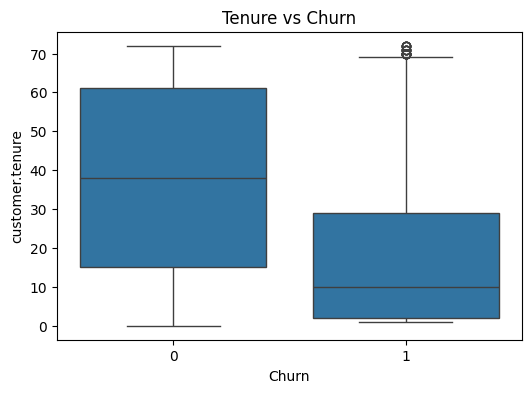

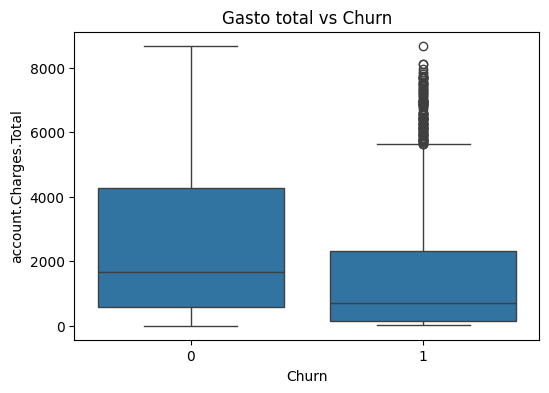

In [13]:
# 7. Análisis dirigido: tenure y account.Charges.Total
plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=datos["customer.tenure"])
plt.title("Tenure vs Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=datos["account.Charges.Total"])
plt.title("Gasto total vs Churn")
plt.show()


##Separación de Datos

In [14]:
# 8. División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, stratify=y, random_state=5
)

X_train_norm, X_test_norm, _, _ = train_test_split(
    X_normalizado, y, test_size=0.3, stratify=y, random_state=5
)


##Creación de Modelos

In [15]:
# 9. Modelos
## Árbol de decisión
arbol = DecisionTreeClassifier(max_depth=5, random_state=5)
arbol.fit(X_train, y_train)
y_pred_arbol = arbol.predict(X_test)

## KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_norm, y_train)
y_pred_knn = knn.predict(X_test_norm)


##Evaluación de los Modelos


Resultados para Árbol de Decisión:
Exactitud: 0.8041
Precisión: 0.6306
Recall: 0.6328
F1-score: 0.6317

Matriz de confusión:


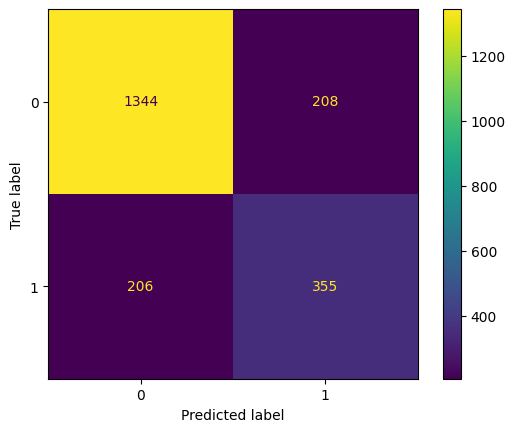


Reporte completo:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1552
           1       0.63      0.63      0.63       561

    accuracy                           0.80      2113
   macro avg       0.75      0.75      0.75      2113
weighted avg       0.80      0.80      0.80      2113


Resultados para KNN:
Exactitud: 0.7629
Precisión: 0.5577
Recall: 0.5169
F1-score: 0.5365

Matriz de confusión:


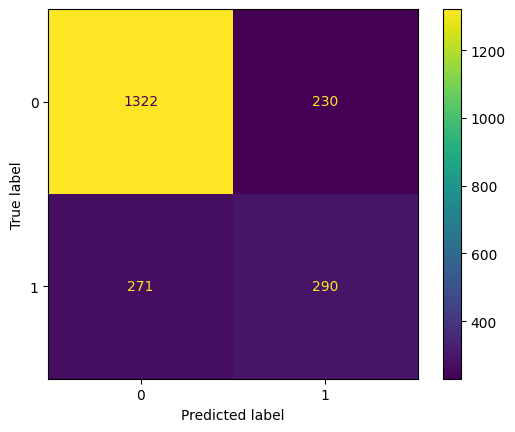


Reporte completo:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1552
           1       0.56      0.52      0.54       561

    accuracy                           0.76      2113
   macro avg       0.69      0.68      0.69      2113
weighted avg       0.76      0.76      0.76      2113



In [16]:
# 10. Evaluación
def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\nResultados para {nombre}:")
    print(f"Exactitud: {accuracy_score(y_true,y_pred):.4f}")
    print(f"Precisión: {precision_score(y_true,y_pred):.4f}")
    print(f"Recall: {recall_score(y_true,y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true,y_pred):.4f}")
    print("\nMatriz de confusión:")
    ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred)).plot()
    plt.show()
    print("\nReporte completo:")
    print(classification_report(y_true,y_pred))

evaluar_modelo("Árbol de Decisión", y_test, y_pred_arbol)
evaluar_modelo("KNN", y_test, y_pred_knn)

##Análisis de la Importancia de las Variables


=== Importancia de variables según Árbol de Decisión ===
onehotencoder__account.Contract_Month-to-month           0.512512
remainder__customer.tenure                               0.161561
onehotencoder__internet.InternetService_Fiber optic      0.131337
onehotencoder__internet.OnlineSecurity_No                0.048846
remainder__Cuentas.diarias                               0.041876
onehotencoder__account.PaymentMethod_Electronic check    0.020011
remainder__account.Charges.Monthly                       0.018148
onehotencoder__phone.MultipleLines_Yes                   0.016948
remainder__account.Charges.Total                         0.012111
onehotencoder__phone.MultipleLines_No phone service      0.011747
dtype: float64


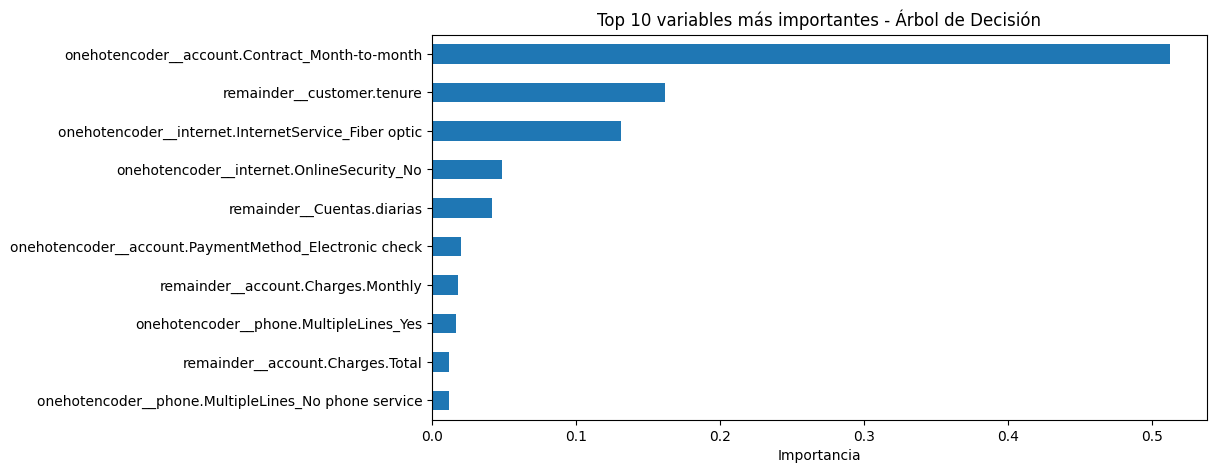

In [17]:

print("\n=== Importancia de variables según Árbol de Decisión ===")
# Feature importance directamente desde el árbol
importancia_arbol = pd.Series(arbol.feature_importances_, index=X_encoded.columns)
importancia_arbol = importancia_arbol.sort_values(ascending=False)
print(importancia_arbol.head(10))  # Mostrar top 10 variables

# Gráfico de barras
plt.figure(figsize=(10,5))
importancia_arbol.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 variables más importantes - Árbol de Decisión")
plt.xlabel("Importancia")
plt.show()

## Conclusión – Análisis de Churn

### Rendimiento de los modelos
- **Árbol de Decisión:** Mejor desempeño (Exactitud: 0.80, F1-score: 0.63). Identifica de manera correcta a los clientes que no cancelan y una proporción razonable de los que sí cancelan.
- **KNN:** Menor desempeño (Exactitud: 0.76, F1-score: 0.54). Parece que subestima clientes que cancelan.

### Principales factores de cancelación
1. **Contrato Month-to-month**: mayor probabilidad de churn.  
2. **Antigüedad del cliente (tenure)**:clientes nuevos cancelan más.  
3. **Internet de fibra óptica**:mayor churn relativo.  
4. **Falta de seguridad en línea (OnlineSecurity_No)**:incrementa cancelaciones.  
5. **Gasto diario bajo (Cuentas.diarias)**:menor compromiso con el servicio.

### Estrategias de retención
- Incentivar contratos a largo plazo.  
- Beneficios para clientes nuevos.  
- Valor agregado a los servicios que brindan.  
- Facilitar métodos de pago automáticos y electrónicos o tener mas terminales para tarjeta.
